In [1]:
import numpy as np
from qiskit import *
import random
import time
from numpy import log as ln
import warnings
warnings.filterwarnings('ignore', module = 'qiskit')
# warnings.filterwarnings(action='once')

from qiskit.algorithms.optimizers import ADAM, AQGD, COBYLA, SPSA, TNC, CG, L_BFGS_B, GSLS, NELDER_MEAD, NFT, P_BFGS, POWELL, SLSQP
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI
from qiskit.opflow import CircuitStateFn, StateFn, I, X, Y, Z, H, CX, Zero, One, OperatorBase

from itertools import combinations as cm

In [2]:
# Generate Primes as an array
primes = [2,3,5]#,7,11,17,19,,31,37]
primes = primes[::-1]

combinations = list(cm(range(len(primes)), 2))

In [3]:
def generate_ZZcircuit(params, primes, assigned=True):
    cir = QuantumCircuit(len(primes))
    layers = int(len(params)/len(primes))
    thetas = [qiskit.circuit.Parameter(str(i)) for i in range(layers*len(primes))]
    thetas_reshape = np.reshape(np.asarray(thetas),(layers, len(primes)))
    params = np.reshape(np.asarray(params),(layers, len(primes)))
    combs = list(cm(range(len(primes)), 2))
#     print(combs)
#     cir.h(range(len(primes)))
    
    for m in range(layers):
        l = len(params)
        g = [ln(2)*ln(30), ln(3)*ln(30),ln(5)*ln(30)]#thetas_reshape[m][0: len(primes)]
        a = [ln(2)*ln(3), ln(2)*ln(5), ln(3)*ln(5)]#thetas_reshape[m][len(primes): (len(primes) + len(combs))]
        b = thetas_reshape[m]
        
        for h in range(len(primes)):
            cir.rz(g[h], h)
        
        i = 0
        for j, k in combs:
            cir.rzz(a[i], j, k)
            i += 1
        for l in range(len(primes)):
            cir.rx(b[l], l)
            
    if assigned == True:
        thetas_reshape = thetas_reshape.flatten()
        params = params.flatten()
        p_dict = {thetas_reshape[i] : params[i] for i in range(len(thetas))}
        cir.assign_parameters(p_dict, inplace=True)
    cir.measure_all()
    
    return cir, thetas

[0.7818618700004596, 2.8350178389352014, 1.9494980851782933, 0.9879911983723001, 0.5847292151715091, 1.395818500173898]


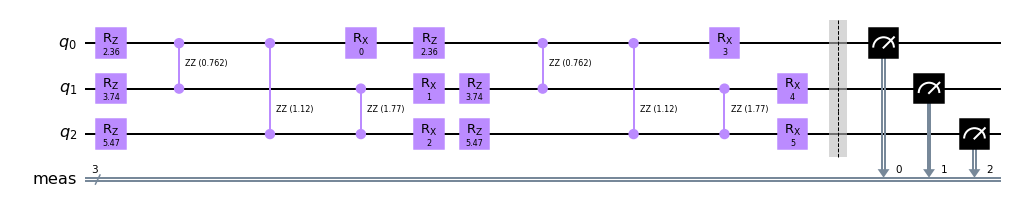

In [4]:
hyperparam = [random.uniform(0,np.pi) for _ in range(2*len(primes))]
print(hyperparam)
cir, free_params = generate_ZZcircuit(hyperparam, primes, assigned=False)
cir.draw('mpl')

In [5]:
def obj_function(counts, n, penalty):
    max_c = 0
    max_bit = ""
    for c in counts:
        if counts[c] >= max_c:
            max_c =  counts[c]
            max_bit = c
    comp_primes = 1
    for i in range(len(max_bit)):
        comp_primes *= primes[i]**int(max_bit[i])
    p = 0
    if penalty == 1:
        if abs(comp_primes-n) > n:
            p += comp_primes**2 
#         return (n - comp_primes)**2
#     print(comp_primes, n-comp_primes, p)
    return (n - comp_primes) + p

In [6]:
def gen_f(n):
    
    def f(theta):
        qc, free_params = generate_ZZcircuit(theta, primes)
        back = Aer.get_backend('aer_simulator')
        back.set_options(device='GPU')
        job_sim = execute(qc, backend = back, shots = 2048).result()
        counts = job_sim.get_counts(qc)
        
        return obj_function(counts, n, 1)

    return f

In [7]:
def X_generator(primes, identity):
    #Generate X value for hamiltonian
    constant = 0

    for i in range(len(primes)):
        #Build Constant value iteratively
        constant += ln(primes[i])
        
        if i == 0:
            z_value = Z
        else:
            z_value = I
        #Build rest of X
        for j in range(1, len(primes)):
            if j == i:
                z_value = z_value ^ Z
            else:
                z_value = z_value ^ I
        if i == 0:
            x = -ln(primes[i]) * z_value
        else:
            x -= ln(primes[i]) * z_value
    #Combine Both to form X
    x += constant * identity
    
    return x

def hamiltonian(n, primes):
    #Generate Hamitonian according to number of primes
    identity = I
    
    for i in range(len(primes) - 1):
        identity = identity ^ I
        
    x = X_generator(primes, identity)
    
    lnn = float(ln(n))
    
    h = ((lnn**2) * identity) - (lnn * x) + (1 / 4 * (x ** 2))
    
    return h

In [8]:
h_value = hamiltonian(5, primes)
print(h_value.to_matrix())

[[ 2.59029039e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  8.39588705e-01+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  2.60942818e-01+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   3.32411501e-02+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j -4.44089210e-16+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  4.80453014e-01+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j

In [9]:
 def _convert_to_gradient_function(gradient_object, layers, n):

        def gradient_function(current_point):

            cir, free_params = generate_ZZcircuit(current_point, primes, assigned=False)
            cir.remove_final_measurements()
            c = hamiltonian(n, primes)
            op = ~StateFn(c) @ CircuitStateFn(primitive=cir, coeff=1.)
            grad_object = gradient_object.convert(operator=op, params=free_params)
            value_dict = {free_params[i]: current_point[i] for i in range(len(free_params))}
            x = grad_object.assign_parameters(value_dict).eval()
#             print(x)
#             analytical_gradients = np.array(x)# Change this part
            return np.real(x)
        
        return gradient_function

In [10]:
def run(optimizer, layers, func, gradient_function, n):
    g_f = _convert_to_gradient_function(gradient_function, layers, n)
    theta = [random.uniform(0, 2 * np.pi) for _ in range(layers * len(primes))]
    theta, loss, _ = optimizer.optimize(
                num_vars=len(theta),
                objective_function=func,
                initial_point=theta,
                gradient_function=g_f
                )
    return loss

gradient_types = ['param_shift'] #['', 'param_shift', 'lin_comb', 'fin_diff']
op_types = [AQGD(maxiter = 100)]#ADAM(maxiter = 100, amsgrad = True), COBYLA(maxiter = 100), TNC(maxiter = 100), CG(maxiter = 100), GSLS(maxiter = 100), NELDER_MEAD(maxiter = 100)]#, NFT(maxiter = 500)]#, P_BFGS(maxfun = 500), POWELL(maxiter = 500), SLSQP(maxiter = 500)]
loss_list = []


for i in range(2, 16):
    print("Current n = ", i)
    fun = gen_f(i)
    n_list = []
    for j in range(1, 2):
        print("Current layer = ", j)
        layer_list = []
        for k in range(len(op_types)):
            print("Current opt = ", k)
            opt = op_types[k]
            grad_list = []
            for g in range(len(gradient_types)):
                print("Current Gradient = ", gradient_types[g] )
#                 if g == 0:
#                     grad = Gradient()
#                 else:
                grad = Gradient(grad_method=gradient_types[g])
                samples = []
                for _ in range(10):
                    start = time.perf_counter()
                    loss = run(opt,  j, fun, grad, i)
                    end = time.perf_counter()
                    samples.append((loss, end - start))
                grad_list.append(samples)
            layer_list.append(grad_list)
        n_list.append(layer_list)
    loss_list.append(n_list)

Current n =  2
Current layer =  1
Current opt =  0
Current Gradient =  param_shift
Current n =  3
Current layer =  1
Current opt =  0
Current Gradient =  param_shift
Current n =  4
Current layer =  1
Current opt =  0
Current Gradient =  param_shift
Current n =  5
Current layer =  1
Current opt =  0
Current Gradient =  param_shift
Current n =  6
Current layer =  1
Current opt =  0
Current Gradient =  param_shift
Current n =  7
Current layer =  1
Current opt =  0
Current Gradient =  param_shift
Current n =  8
Current layer =  1
Current opt =  0
Current Gradient =  param_shift
Current n =  9
Current layer =  1
Current opt =  0
Current Gradient =  param_shift
Current n =  10
Current layer =  1
Current opt =  0
Current Gradient =  param_shift
Current n =  11
Current layer =  1
Current opt =  0
Current Gradient =  param_shift
Current n =  12
Current layer =  1
Current opt =  0
Current Gradient =  param_shift
Current n =  13
Current layer =  1
Current opt =  0
Current Gradient =  param_shift


In [11]:
print(loss_list)

[[[[[(0, 7.14944325198303), (0, 5.775661363004474), (-1, 5.9469185970083345), (1, 7.4209983269975055), (0, 9.75361257098848), (0, 5.837634166993666), (0, 8.473038141994039), (0, 9.819128428993281), (0, 7.061231883999426), (-1, 7.886522358021466)]]]], [[[[(-2, 6.432911342999432), (1, 5.795965159981279), (0, 8.766247622988885), (1, 6.608311968011549), (1, 6.0932436019938905), (-2, 6.052870315994369), (1, 6.027853851992404), (1, 6.557240889989771), (0, 5.937582527985796), (0, 6.6308140070177615)]]]], [[[[(-1, 6.945637253986206), (-2, 6.14154116800637), (1, 7.0854159140144475), (-2, 5.935169328993652), (1, 6.70433546800632), (-1, 10.032442152994918), (-2, 9.300653699989198), (-1, 8.173299654998118), (-1, 7.609490488015581), (-1, 7.071730190014932)]]]], [[[[(-1, 5.962207695003599), (-5, 6.085096804017667), (0, 11.658581141993636), (2, 6.057513829000527), (0, 5.947577924991492), (0, 6.487147247011308), (-5, 10.709005247015739), (-1, 8.101796609000303), (0, 5.835211486002663), (0, 8.533473151

In [12]:
ll = np.asarray(loss_list)
ll.shape

(14, 1, 1, 1, 10, 2)

In [13]:
np.save("Test_nPhase_nH_Penalty_AQGD_l1", ll,)